<a href="https://colab.research.google.com/github/Jbridg12/Alzheimer_GAN/blob/main/AlzheimersGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initial Setup

In [5]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras.utils import image_dataset_from_directory
tf.config.run_functions_eagerly(True)

In [1]:
import os
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/"

In [3]:
%cd /content/gdrive/MyDrive/

/content/gdrive/MyDrive


# Image Processing

In [5]:
!kaggle datasets download -d sachinkumar413/alzheimer-mri-dataset

In [6]:
from zipfile import ZipFile
with ZipFile('alzheimer-mri-dataset.zip', 'r') as zipper:
  zipper.extractall()

In [5]:
from os import listdir
from os.path import join, isdir
class_name = np.array([f for f in listdir('./Dataset') if isdir(join('./Dataset', f))])
n_classes = len(class_name)
print(n_classes)

4


In [ ]:
# From https://opensource.com/article/17/2/python-tricks-artists
from os import listdir
from PIL import Image

bad_files = []
for dir in listdir('Dataset/'):
  for file in listdir('Dataset/'+dir):
    # print(file)
    # break
    if file.endswith('.jpg'):
      try:
        img = Image.open('Dataset/'+dir+'/'+file)
        img.verify()
      except (IOError, SyntaxError) as e:
        print('Bad file:', file)
        path = 'Dataset/'+dir+'/'+file
        bad_files.append(path)

In [ ]:
print(len(bad_files))
for file in bad_files:
  os.remove(file)

In [6]:
# For replicable results
SEED = 0
# Size of Latent Input
noise_dim = 100
num_examples_to_generate = 16
# Size of the images is (128,128)
IMAGE_SIZE = (128, 128)
# Default batch size
BATCH_SIZE = 32
# Images are grayscale
COLOR_MODE = "grayscale"

# data_dir = "Dataset/"
data_dir=os.path.join('train_test/', 'train')

tf.random.set_seed(SEED)
np.random.seed(SEED)

train_data = tf.keras.preprocessing.image_dataset_from_directory(
    'Dataset/',
    validation_split=0.2,
    subset="training",
    seed=SEED,
    color_mode=COLOR_MODE,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)


Found 6400 files belonging to 4 classes.
Using 5120 files for training.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


In [7]:
for i, l in train_data:
  print(i.shape)
  break

(32, 128, 128, 1)


# Generate Examples

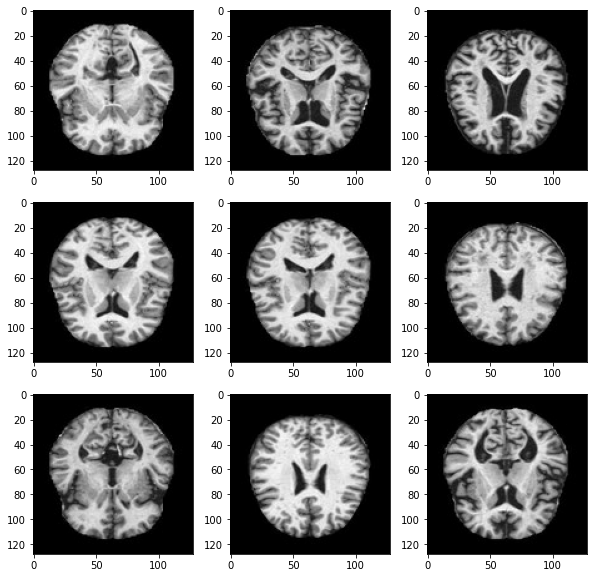

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(tf.image.grayscale_to_rgb(images[i]).numpy().astype("uint8"))


In [9]:
def process(image,label):
    image = tf.cast(((tf.cast(image, tf.float32)/127.5) -1)  ,tf.float32)
    return image,label

train_data = train_data.map(process)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


# Define Model Architectures

In [12]:
def generator_model():
  model = tf.keras.Sequential()
  model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(noise_dim+1,)))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Reshape((8, 8, 256)))
  assert model.output_shape == (None, 8, 8, 256)

  model.add(layers.Conv2DTranspose(128, (3, 3), strides=(1, 1), padding='same', use_bias=False))
  assert model.output_shape == (None, 8, 8, 128)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', use_bias=False))
  assert model.output_shape == (None, 16, 16, 128)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(64, (3, 3), strides=(1, 1), padding='same', use_bias=False))
  assert model.output_shape == (None, 16, 16, 64)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', use_bias=False))
  assert model.output_shape == (None, 32, 32, 64)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(32, (3, 3), strides=(1, 1), padding='same', use_bias=False))
  assert model.output_shape == (None, 32, 32, 32)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same', use_bias=False))
  assert model.output_shape == (None, 64, 64, 32)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(16, (3, 3), strides=(1, 1), padding='same', use_bias=False))
  assert model.output_shape == (None, 64, 64, 16)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(16, (3, 3), strides=(2, 2), padding='same', use_bias=False))
  assert model.output_shape == (None, 128, 128, 16)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())


  model.add(layers.Conv2DTranspose(1, (3, 3), strides=(1, 1), padding='same', use_bias=False, activation='tanh'))
  assert model.output_shape == (None, 128, 128, 1)

  return model

In [10]:
def discriminator_model():
  logitmodel = tf.keras.Sequential()

  logitmodel.add(layers.Conv2D(64,3,2,'same', input_shape=(128,128,1)))
  logitmodel.add(layers.LeakyReLU())
  logitmodel.add(layers.Dropout(0.3))

  logitmodel.add(layers.Conv2D(128,3,2,'same'))
  logitmodel.add(layers.LeakyReLU())
  logitmodel.add(layers.Dropout(0.3))

  logitmodel.add(layers.Conv2D(64,3,2,'same'))
  logitmodel.add(layers.LeakyReLU())
  logitmodel.add(layers.Dropout(0.3))

  logitmodel.add(layers.Conv2D(32,3,2,'same'))
  logitmodel.add(layers.LeakyReLU())
  logitmodel.add(layers.Dropout(0.3))

  logitmodel.add(layers.Conv2D(8,3,2,'same'))
  logitmodel.add(layers.LeakyReLU())
  logitmodel.add(layers.Dropout(0.3))

  logitmodel.add(layers.Flatten())
  logitmodel.add(layers.Activation('sigmoid'))
  logitmodel.add(layers.Dense(1))
  
  return logitmodel

In [13]:
generator = generator_model()
discriminator = discriminator_model()

In [ ]:
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

In [ ]:
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

# Define Loss and Optimizers

In [16]:
ent_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [17]:
def discriminator_loss(real_output, fake_output):
    real_loss = ent_loss(tf.ones_like(real_output), real_output)
    fake_loss = ent_loss(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [18]:
def generator_loss(fake_output):
    return ent_loss(tf.ones_like(fake_output), fake_output)

In [19]:
gen_lr = 0.0001
dis_lr = 0.0001

generator_optimizer = tf.keras.optimizers.Adam(gen_lr)
discriminator_optimizer = tf.keras.optimizers.Adam(dis_lr)

# Training

In [20]:
import sys
@tf.function
def train_step(image, label):

    # Add label to noise and images
    noise = tf.random.normal((label.shape[0], noise_dim)).numpy()
    l = label.numpy()
    noises = []
    for i in range(l.shape[0]):
      noises.append(np.append(noise[i], l[i]))
    
    n_and_l = tf.convert_to_tensor(np.array(noises))

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

      generated_images = generator(n_and_l, training=True)

      real_output = discriminator(image, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [21]:
import time
def train(dataset, epochs):
  for (step, input_image) in train_data.repeat().take(EPOCHS).enumerate():
    start = time.time()

    train_step(input_image[0], input_image[1])      

    print ('Time for epoch {} is {} sec'.format(step + 1, time.time()-start))


In [ ]:
EPOCHS = 7000
train(train_data, EPOCHS)

In [ ]:
num_labels = np.arange(0, n_classes).reshape(-1, 1)
print(num_labels.shape)

# Example

In [ ]:
target_label = 3

test_noise = tf.random.normal([1, noise_dim]).numpy()
tst_in = []
tst_in.append(np.append(test_noise[0], target_label))
test_input = tf.convert_to_tensor(np.array(tst_in))
gen_img = generator(test_input, training=False)
plt.imshow(gen_img[0,:,:,0], cmap='gray')

# Save Model

In [ ]:
generator.save('saved_model/gen1')